# Generative models

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Auto-Encoder

Before creating generative models, let's first discuss a non-generative model called the Auto-Encoder (AE). The AE takes as an input some $X$ and tries to compress this input via the encoder part of the network. As a result, we can encode $X$ to get a latent variable $Z$. Then we decode the latent $Z$ to get a reconstruction of $X$, which we denote as $\tilde{X}$. The idea is to learn a mapping from the input to itself, i.e., we want to learn a function
$$
    f: X \rightarrow X
$$
Our learning objective is therefore to change the weights of both the encoder and the decoder such that $X \approx \tilde{X}$. In other words, we want our reconstructed $\tilde{X}$ to be as similar as possible to our original input $X$. After training the network in this way, we get a model that is able to compress its input into a (lower) dimensional space, which we denote as $Z$. Thus, we are not actually interested in the reconstructed input $\tilde{X}$, but rather, we are interested in learning how to encode the input $X$ and how to decode the latent $Z$.  

One key observation is that the latent space $Z$ is **not** probabilistic. Let's implement the AE to see why this is the case. We will be using the MNIST dataset again, and our encoder/decoder will consist of a stack of convolutional layers that sequentially learn to compress the input image $X$ into $Z$, and learn to upscale and transform the latent $Z$ into the reconstructed input $\tilde{X}$. 

For this, let's first write down the dimensions to get a good idea what the transformations will do to our input. 

Input to the **encoder** has the shape `(batch_size, channels, height, width)`. In the case of MNIST, we are working with black-white images of $28 \times 28$. In this example, the MNIST images are first resized so that they are $32 \times 32$. In each convolutional layer, we increase the amount of output channels, while halving both the height and the width of the input image. This is laid out in the following steps: 
1. `(batch_size, 1, 32, 32)`
2. `(batch_size, 64, 16, 16)`
3. `(batch_size, 128, 8, 8)`
4. `(batch_size, 256, 4, 4)`
5. `(batch_size, z_size, 1, 1)`

Notice that from the 4th to the 5th layer, we actually transform 256 channels that are each $4\times 4$ into `z_size` channels that are each $1\times 1$. In other words, the variable `z_size` dictates how many dimensions our latent space has.  

Input to the **decoder** has the shape `(batch_size, z_size, 1, 1)`. To decode the latent variable back into an image, we apply the transformations of the encoder in reverse order:
1. `(batch_size, z_size, 1, 1)`
2. `(batch_size, 256, 4, 4)`
3. `(batch_size, 128, 8, 8)`
4. `(batch_size, 64, 16, 16)`
5. `(batch_size, 1, 32, 32)`

Notice how playing around with the `kernel_size`, `stride`, and `padding` parameters of the `nn.Conv2d` layer can decrease the dimensionality of the input image. Also notice that to increase the dimensionality in the decoder part, we need to use `nn.ConvTranspose2d` layers, which create new features instead of reducing the features in the input. 

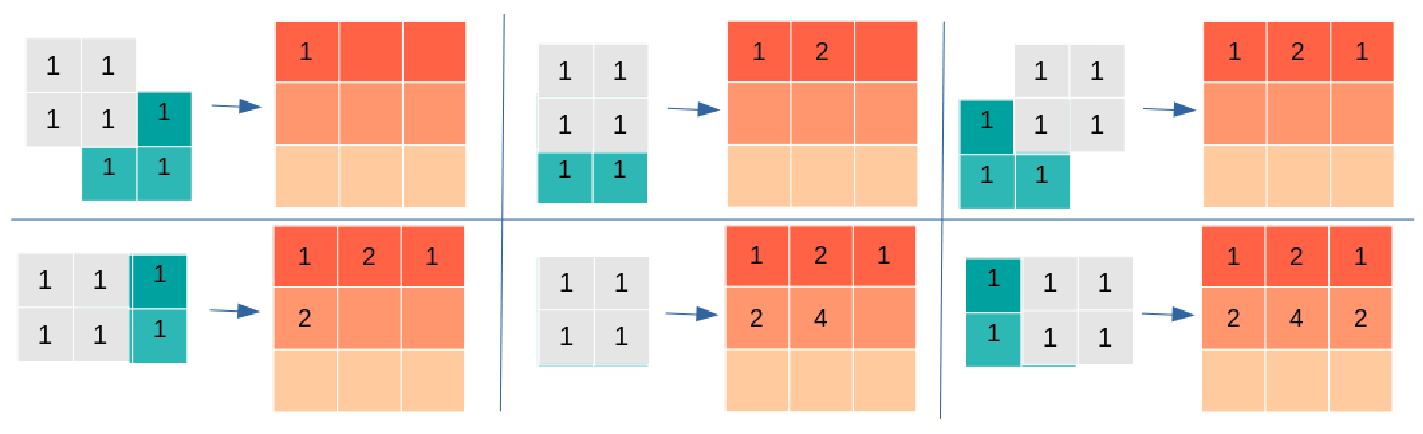

*Read more about transposed convolutional layers here: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d*

In [2]:
class Encoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 32 -> 16
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(256, z_size, kernel_size=3, stride=2, padding=0, bias=False),
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

class Decoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)
    
    
class AutoEncoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.enc = Encoder(z_size)
        self.dec = Decoder(z_size)

    def forward(self, X: torch.Tensor):
        z = self.enc(X)
        y = self.dec(z)
        return y, z

# let's test it out on some random input
x = torch.randn(64, 1, 32, 32)
generator = AutoEncoder(z_size=20)
y, z = generator(x)
y.shape, z.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64, 20, 1, 1]))

### Training Auto-Encoder

For the training regime, we split the MNIST dataset in train/test/validation sets according to a 60000/5000/5000 distribution.   

In [4]:
# Training constants
EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 0.03
LEARNING_RATE_GAMMA = 0.9

# Model constants
Z_DIM = 2

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]))

Some important training considerations are the following. Adam optimizer is used, as it generally performs better than standard SGD. We introduce a learning rate scheduler, which updates the learning rate after each epoch according to some scheme. In this case, the learning is exponentially decayed by a `gamma` value which we set at 0.9. 

For the loss, we use the Binary Cross-Entropy with logits loss. Since our MNIST imageset is normalized to be in the range $[0, 1]$, we would ideally apply a sigmoid layer at the end of the decoder so that our reconstruction also lies within the range $[0, 1]$. However, in this case, for numeric stability, we did not include the sigmoid layer. Instead we can regard our outputs as "pre-sigmoid" outputs, which we often just call **logits** (speak: "lodzjits"). The `BCEWithLogitsLoss` implicitly applies a numerically stable sigmoid and calculates the BCE loss. Alternatives would be the use of the MSE loss. However, the nice property of the BCE is that reconstruction mistakes are penalized more harshly, leading to gradients that are a bit bigger than the gradients produced by the MSE loss.  

Notice that when we test our trained model against the test set, that we maintain the latent $Z$ variable, so that we can visualize its contents next.  

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

generator = AutoEncoder(z_size=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        # predict and compute loss
        preds, _ = generator(images)
        loss = criterion(preds, images)
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _ = generator(X_val.to(DEVICE))
        loss = criterion(preds, X_val.to(DEVICE))
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")


# TEST
with torch.no_grad():
    preds, z = generator(X_test.to(DEVICE))
    loss = criterion(preds, X_test.to(DEVICE))
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 0.25205132365226746, val_loss 0.21587041020393372
epoch 1, train_loss 0.2098122090101242, val_loss 0.2045677900314331
epoch 2, train_loss 0.20317481458187103, val_loss 0.20088507235050201
epoch 3, train_loss 0.19962038099765778, val_loss 0.19876834750175476
epoch 4, train_loss 0.19687773287296295, val_loss 0.1962074339389801
epoch 5, train_loss 0.19516977667808533, val_loss 0.19414885342121124
epoch 6, train_loss 0.19352588057518005, val_loss 0.19335192441940308
epoch 7, train_loss 0.19178985059261322, val_loss 0.19285455346107483
epoch 8, train_loss 0.19092270731925964, val_loss 0.19056636095046997
epoch 9, train_loss 0.18993066251277924, val_loss 0.1905186027288437
epoch 10, train_loss 0.18878526985645294, val_loss 0.1897694170475006
epoch 11, train_loss 0.1879974752664566, val_loss 0.18967577815055847
epoch 12, train_loss 0.18719878792762756, val_loss 0.1882781684398651
epoch 13, train_loss 0.1866300404071808, val_loss 0.18767040967941284
epoch 14, train_loss 0.1

### Visualize training procedure and latent $Z$-space

Using the latent $Z$ variable whose values are produced by the test set, we can visualize the $Z$ latent variable (since we set its dimensionality to be two). 

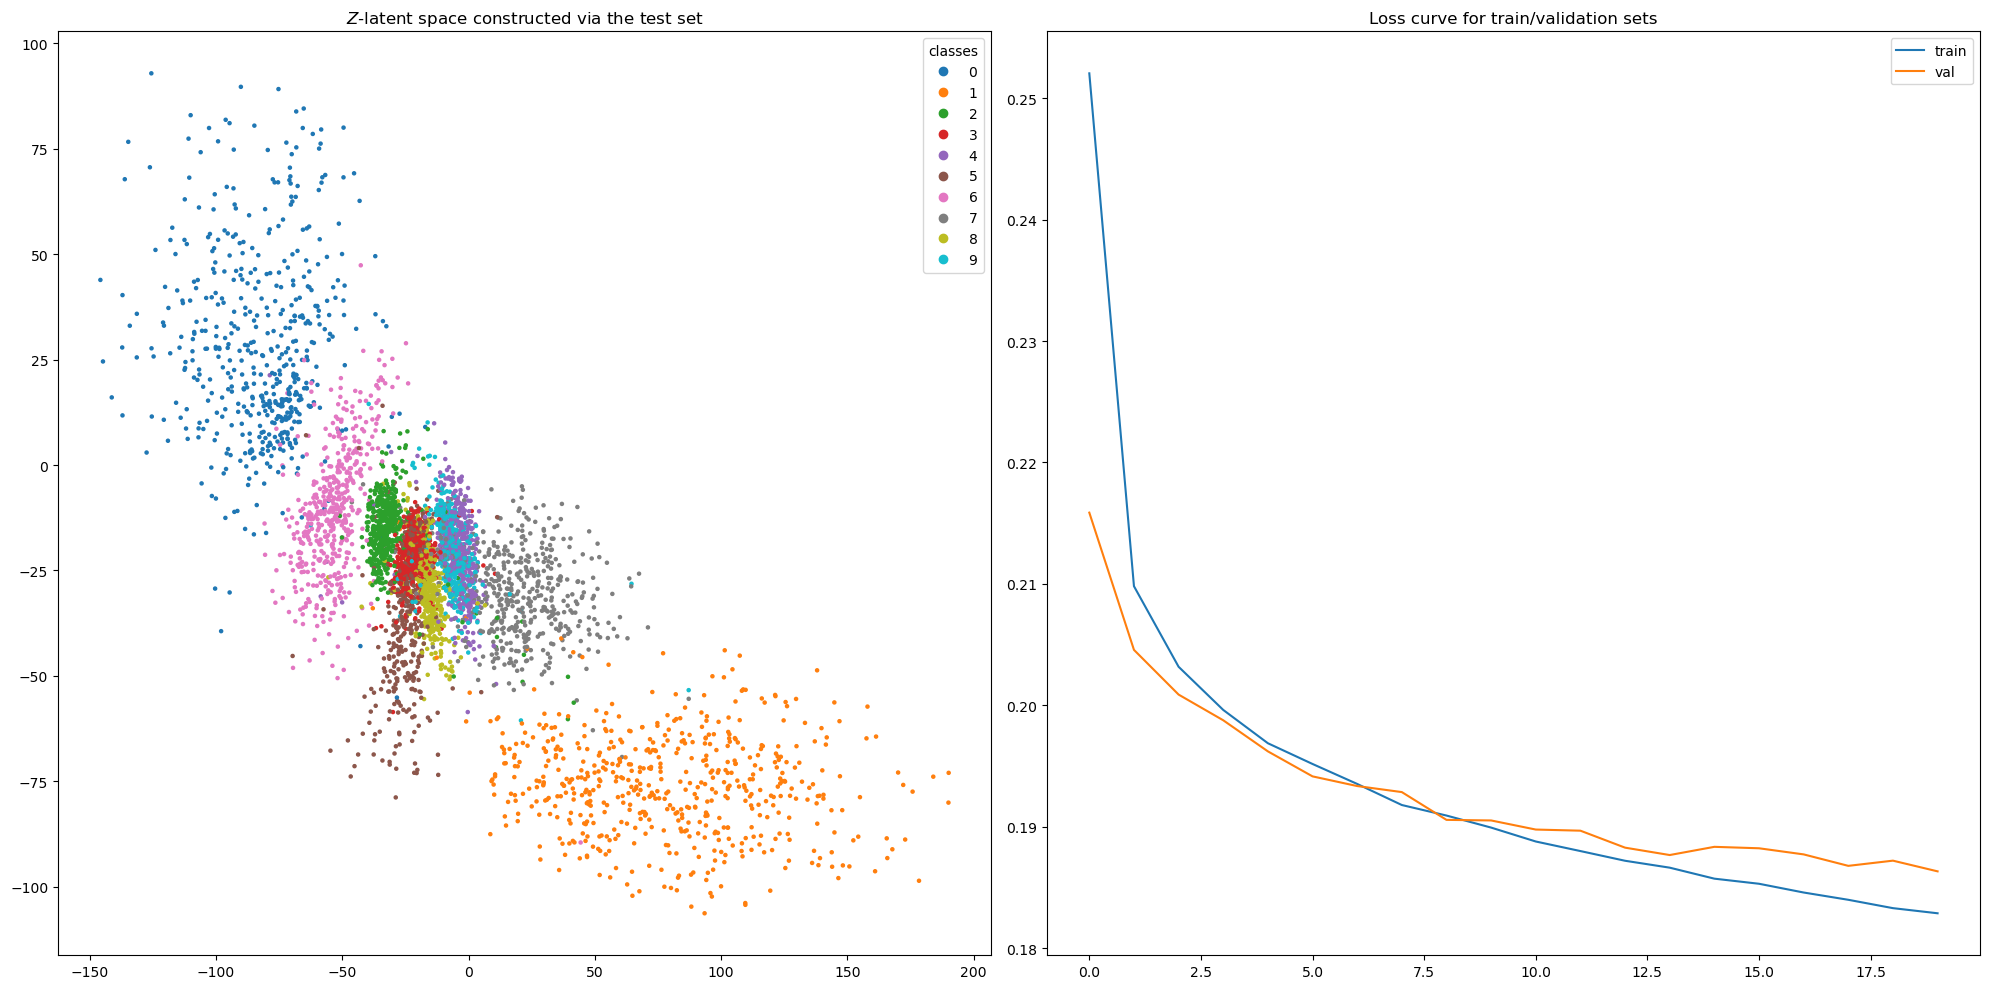

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

z = z.squeeze().cpu().detach()
sc = ax1.scatter(z[:, 0], z[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')
ax1.set_title("$Z$-latent space constructed via the test set")

ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()
ax2.set_title("Loss curve for train/validation sets")

plt.tight_layout()

### Generating samples

Now that we have trained an Auto-Encoder, we can take random samples and see how they get reconstructed by the AE. Notice that we applied a sigmoid to the predictions since we assumed that the model outputs pre-sigmoid logits. 

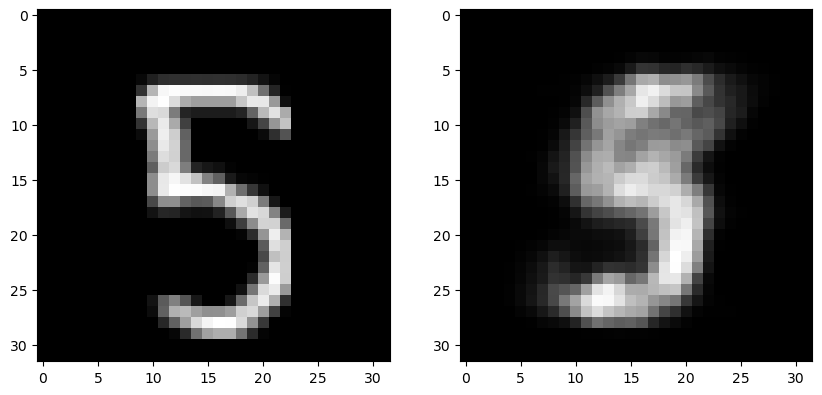

In [25]:
idx = 100

y_pred, _ = generator(X_test[idx][None, :].to(DEVICE))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(X_test[idx][None, :].squeeze(), cmap='gray')
ax2.imshow(F.sigmoid(y_pred).cpu().squeeze().detach(), cmap='gray')
plt.show()

Another interesting property of a low dimensional latent space is that we can interpolate the latent space to see how certain values for $Z$ get decoded, i.e., get reconstructed. 

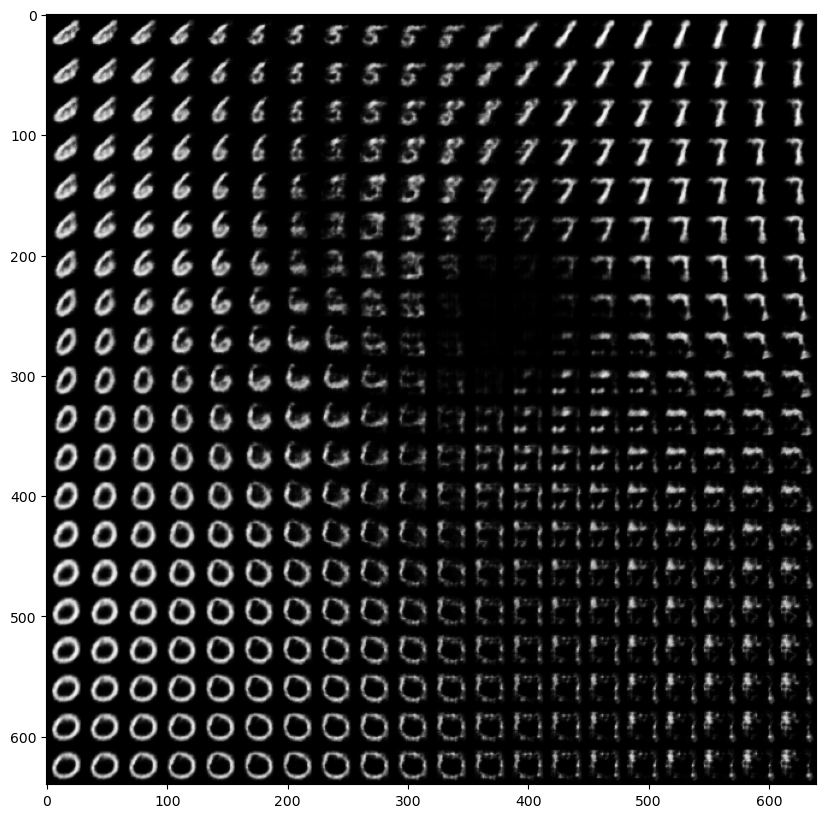

In [34]:
# height, width, ranges for Z 
h = w = 20
z1_range = torch.linspace(-100, 100, h) - 20
z2_range = torch.linspace(-100, 100, w) + 20

# we create a meshgrid of all possible values in z1, z2 ranges
z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to(DEVICE)

# predict the Z space
y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 32, 32).permute(1, 2, 0, 3).reshape(h*32, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')

## Variational Auto-Encoder

In the Variational Auto-Encoder, we apply the same idea of reconstructing our input $X$ as $\tilde{X}$ via an encoder and decoder architecture. The only difference is now that we define the latent $Z$ space to be probabilistic. In other words, we put some constrains on the $Z$-space so that we can interpret it as a probability distribution. The nice property of this probabilistic nature is then that we can coherently sample from the distribution, and therefore, generate new reconstructions. 

We may choose the probability distribution $p(Z)$, but in terms of implementation, choosing $p(Z)$ to be Gaussian has many "nice" properties. For one, a Gaussian distribution can be described by two parameters. These are the mean $\mu$ and the variance $\sigma^2$. Our encoder-decoder pipeline is now as follows. We start with some input image $X$ and encode it into a mean $\mu$ and variance $\sigma^2$. We then use these to sample a $Z \sim \mathcal{N}(\mu, \sigma^2)$. This $Z$ is then decoded into a reconstruction of the input $\tilde{X}$. 

These is one problem with this approach. Since $Z$ is sampled according to a probability distribution, we are unable to backpropagate through $Z$ to adjust the weights of the encoder. In other words, we are stuck! Fortunately, since we decided upon using a Gaussian to represent $p(Z)$, we can reformulate the distribution $\mathcal{N}(\mu, \sigma^2)$ as 

$$
    \mathcal{N}(\mu, \sigma^2) = \mu + \sigma^2 \epsilon
$$
where we let the **randomness** come from an external source $\epsilon \sim \mathcal{N}(0, \textbf{1})$. This way, $\mu$ and $\sigma^2$ are independent of the random process and can be optimized. This is also referred to as the **reparameterization trick**. 

Practically, since $\sigma^2$ must be non-negative, we instead model the logarithm of $\sigma^2$ and exponentiate it when needed. Thus, given an encoder, we get
$$
    [\mu, \log(\sigma^2)] = \text{Encoder}(X)
$$
In other words, our encoder should return both the mean $\mu$ and the logarithm of the variance $\sigma^2$. 

To optimize the VAE, we can again use the Binary Cross-Entropy loss with an added term. We add this additional term to regularize the $Z$-space (or in other words $p(Z)$). This added term should quantify how similar the encoded $Z$-space is to a Gaussian of the form $p(Z) = \mathcal{N}(0, \textbf{1})$. Why? Well, we regularize the distribution that we will learn such that it is a simple Gaussian $\mathcal{N}(0, \textbf{1})$, which makes sampling also simple. Of course, we could have chosen any distribution to compare to our $Z$-space distribution. The question now remains: how do you measure the similarity between two probability distributions. One way to do this is by using the so-called Kullback-Leibner (KL) divergence, which is defined as 

$$
    KL(q(\mathbf{Z}) || p(\mathbf{Z})) = E_{Z \sim q}[\log q(\mathbf{Z}) - \log p(\mathbf{Z})]
$$
where $q$ is our encoder distribution and $p$ is our prior distribution which we parameterize as $\mathcal{N}(0, I)$. The KL-divergence term acts as a regularizer to the loss. Fortunately, since we are measuring similarity between two Gaussians via the KL-divergence, it has a very simple form, defined as:

$$
    KL(q(\mathbf{Z} | X; \theta) || p(\mathbf{Z})) = - \frac{1}{2} \sum 1 + \log(\sigma^2) - \mu^2 - \sigma^2
$$

where $q(\mathbf{Z} | X; \theta)$ is our encoder, taking $X$ and producing a distribution over $Z$ by using learnable parameters $\theta$. 



torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))

In summary, the loss becomes:

$$
    L = \text{BCELoss}(X, \tilde{X}) + KL(q(\mathbf{Z} | \mathbf{X}; \phi) || p(\mathbf{Z} | \mathbf{X}))
$$


- The objective function is to minimize the negative log likelihood: 
    - $-\log p(\mathbf{x}; \theta) = - \mathcal{L}(\phi, \theta; \mathbf{x}) + D_{KL}(q(\mathbf{z} | \mathbf{x}; \phi) || p(\mathbf{z} | \mathbf{x}; \theta))$
    - where:
    - $- \mathcal{L}(\phi, \theta; \mathbf{x}) = - \sum q(\mathbf{z} | \mathbf{x}; \phi) \log \dfrac{p(\mathbf{x}, \mathbf{z}; \theta)}{q(\mathbf{z} | \mathbf{x}; \phi)} = - \mathbb{E}_{q(\mathbf{z} | \mathbf{x}; \phi)} [\log p(\mathbf{x}, \mathbf{z}; \theta)]$ = Binary cross entropy if we parameterize $p(x | z)$ as bernoulli (0 or 1)
    - $D_{KL}(q(\mathbf{z} | \mathbf{x}; \phi) || p(\mathbf{z} | \mathbf{x}; \theta))$ measures the similarity between $q$ and $p$. The prior $p$ is taken as $\mathcal{N}(0, I)$ and the KL divergence term acts as a regularizer.

Kullback-Leibner divergence

- $Kl(Q(x) || P(x)) = E_{x \sim Q}[\log Q(x) - \log P(x)]$
- measures how close $Q$ is to $P$
- can be used as a regularizer to ensure that a learned approximate model $Q$ is encouraged to be close to some prior $P$

(tensor(177.1359), tensor(177.1359))

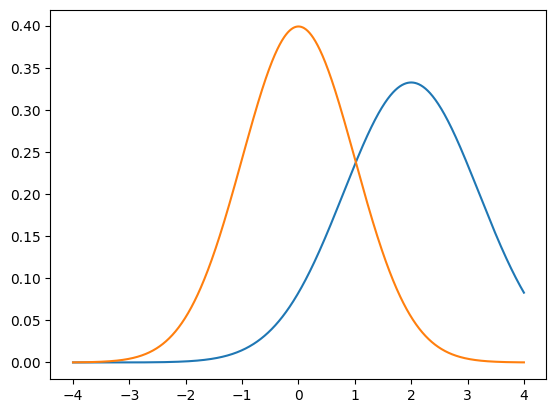

In [ ]:
gaussian = lambda x, mu, sigma: 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

x = torch.linspace(-4, 4, 1000)

p = gaussian(x, 2, 1.2)
q = gaussian(x, 0, 1)

plt.plot(x, p)
plt.plot(x, q)

# kl(q || p) = sum q(x) (log q(x) - log p(x))
kl = torch.sum(q * (torch.log(q) - torch.log(p)))

# pytorch: input is p(x) in log-space and target is q(x)
kl, F.kl_div(torch.log(p), q, reduction='sum')

In [8]:
class VAE(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.enc = Encoder(2*z_size)
        self.dec = Decoder(z_size)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X) # (batch_size, 2*z_dim, 1, 1)
        mu = h[:, :self.z_size].view(-1, self.z_size)       # mean vec mu: (batch_size, z_dim)
        log_var = h[:, self.z_size:].view(-1, self.z_size)  # log variance:(batch_size, z_dim)
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        eps = torch.randn(mu.shape[0], self.z_size).to(mu.device) # random eps \sim N(0, I)
        z = mu + torch.exp(0.5 * log_var) * eps
        z = z.reshape(*z.shape, 1, 1) # (batch_size, z_dim, 1, 1)
        y = self.dec(z)
        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)
        return y, z, mu, log_var
    
x = torch.randn(16, 1, 32, 32)
g = VAE(z_size=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 1, 32, 32]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

### Training VAE

In [344]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]))

In [345]:
EPOCHS = 20
Z_SIZE = 2
lambda_rec_error = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)

generator = VAE(z_size=Z_SIZE).to('cuda')

optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to('cuda')
        # predict and compute loss
        preds, _, mu, log_var = generator(images)
        
        # from the original VAE paper
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _, mu, log_var = generator(X_val.to('cuda'))
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, X_val.to('cuda'))
        loss = rec_error + kl_reg
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds, z, mu, sigma = generator(X_test.to('cuda'))
    kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    rec_error = lambda_rec_error * criterion(preds, X_test.to('cuda'))
    loss = rec_error + kl_reg
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 27.657501220703125, val_loss 24.910690307617188
epoch 1, train_loss 24.854610443115234, val_loss 24.63298225402832
epoch 2, train_loss 24.56538963317871, val_loss 24.345855712890625
epoch 3, train_loss 24.38933563232422, val_loss 24.226062774658203
epoch 4, train_loss 24.26948356628418, val_loss 24.151655197143555
epoch 5, train_loss 24.163808822631836, val_loss 24.00150489807129
epoch 6, train_loss 24.11750602722168, val_loss 23.971874237060547
epoch 7, train_loss 24.04973793029785, val_loss 23.86090660095215
epoch 8, train_loss 23.99986457824707, val_loss 23.903013229370117
epoch 9, train_loss 23.933902740478516, val_loss 23.891246795654297
epoch 10, train_loss 23.907991409301758, val_loss 23.795446395874023
epoch 11, train_loss 23.875341415405273, val_loss 23.789278030395508
epoch 12, train_loss 23.851181030273438, val_loss 23.76405906677246
epoch 13, train_loss 23.8269100189209, val_loss 23.699190139770508
epoch 14, train_loss 23.804697036743164, val_loss 23.720

### Visualize training procedure and latent $z$-space  

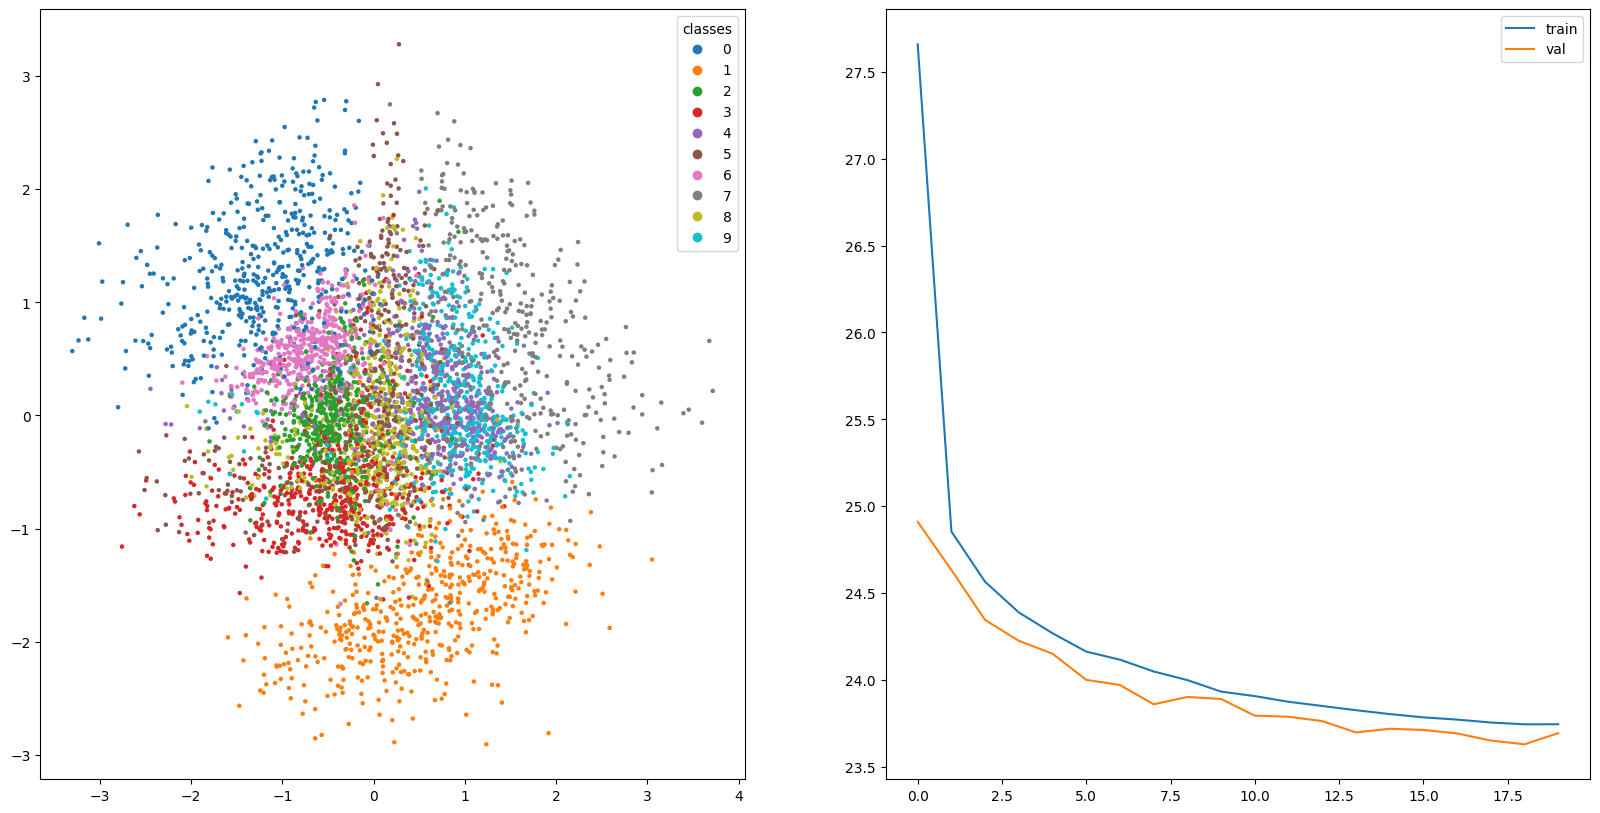

In [346]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

z = z.squeeze().cpu().detach()
sc = ax1.scatter(z[:, 0], z[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')

ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()

### Generating samples

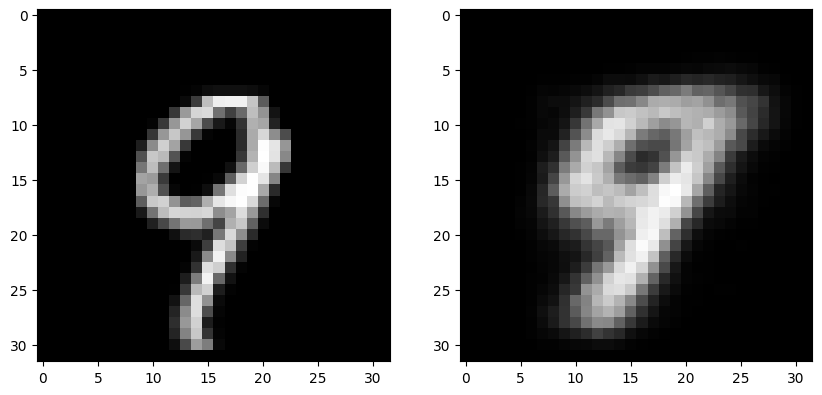

In [347]:
idx = 11
X_sample = X_test[idx].unsqueeze(1).to('cuda')

y_pred, _, _, _ = generator(X_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(X_test[idx][None, :].squeeze(), cmap='gray')
ax2.imshow(F.sigmoid(y_pred).cpu().squeeze().detach(), cmap='gray')
plt.show()

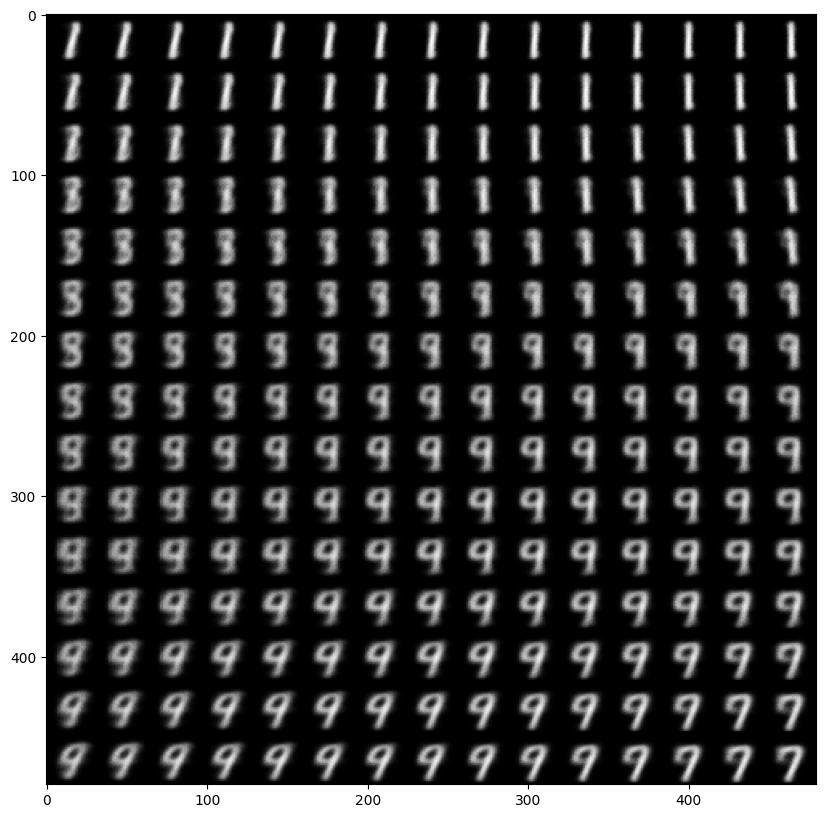

In [348]:
h, w = 15, 15
z1_range = torch.linspace(25, 75, h)
z2_range = torch.linspace(-75, 25, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 32, 32).permute(1, 2, 0, 3).reshape(h*32, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')

## Another VAE example 

In [4]:
import scipy.io
mat = scipy.io.loadmat('../datasets/olivettifaces.mat')

### train/test/val split

In [5]:
dataset = (mat['faces'].T.reshape(-1, 1, 64, 64))
dataset = np.transpose(dataset, axes=(0, 1, 3, 2)).astype('float32')

dataset = (dataset - np.min(dataset))/np.ptp(dataset)

dataset = torch.tensor(dataset)

mask = np.ones((dataset.shape[0]), bool)
idx = np.random.choice(dataset.shape[0], size=int(0.2 * dataset.shape[0]), replace=False)
mask[idx] = False

X_train = dataset[mask]
X_test = dataset[~mask][:idx.shape[0]//2]
X_val = dataset[~mask][idx.shape[0]//2:]

(X_train.shape, X_test.shape, X_val.shape)

(torch.Size([320, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]))

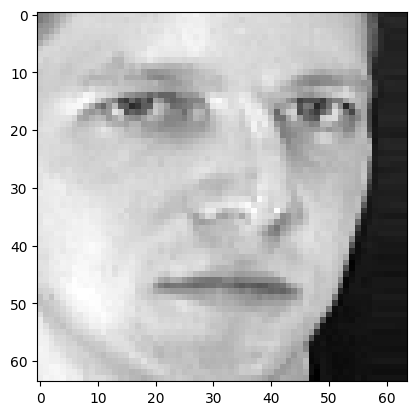

In [6]:
plt.imshow(X_train[0].squeeze(), cmap='gray')

### add extra encoder/decoder layer for 64 x 64 images

In [7]:
class Encoder64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 64 -> 32
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 16
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(512, z_size, kernel_size=3, stride=2, padding=0, bias=False),
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

class Decoder64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 64
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)
    
enc = Encoder64x64(2)
dec = Decoder64x64(2)
x = torch.randn(16, 1, 64, 64)
dec(enc(x)).shape

torch.Size([16, 1, 64, 64])

In [209]:
class VAE64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.enc = Encoder64x64(2*z_size)
        self.dec = Decoder64x64(z_size)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X) # (batch_size, 2*z_dim, 1, 1)
        mu = h[:, :self.z_size].view(-1, self.z_size)       # mean vec mu: (batch_size, z_dim)
        log_var = h[:, self.z_size:].view(-1, self.z_size)  # log variance:(batch_size, z_dim)
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        eps = torch.randn(mu.shape[0], self.z_size).to(mu.device) # random eps \sim N(0, I)
        z = mu + torch.exp(0.5 * log_var) * eps
        z = z.reshape(*z.shape, 1, 1) # (batch_size, z_dim, 1, 1)
        y = self.dec(z)
        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)
        return y, z, mu, log_var
    
x = torch.randn(16, 1, 64, 64)
g = VAE64x64(z_size=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 1, 64, 64]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

### Training procedure

In [317]:
EPOCHS = 100
Z_SIZE = 2
lambda_rec_error = 1000

train_loader = torch.utils.data.DataLoader(X_train, batch_size=8, shuffle=True)

generator = VAE64x64(z_size=Z_SIZE).to('cuda')

optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, images in enumerate(train_loader):
        images = images.to('cuda')
        # predict and compute loss
        preds, _, mu, log_var = generator(images)
        
        # from the original VAE paper
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _, mu, log_var = generator(X_val.to('cuda'))
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, X_val.to('cuda'))
        loss = rec_error + kl_reg
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds, z, mu, sigma = generator(X_test.to('cuda'))
    kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    rec_error = lambda_rec_error * criterion(preds, X_test.to('cuda'))
    loss = rec_error + kl_reg
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 728.32861328125, val_loss 697.404296875
epoch 1, train_loss 678.8284301757812, val_loss 683.1293334960938
epoch 2, train_loss 669.2101440429688, val_loss 677.3701782226562
epoch 3, train_loss 665.0338134765625, val_loss 677.4835205078125
epoch 4, train_loss 662.3800048828125, val_loss 673.7244873046875
epoch 5, train_loss 660.7258911132812, val_loss 675.0357055664062
epoch 6, train_loss 660.5160522460938, val_loss 672.9893798828125
epoch 7, train_loss 659.8724365234375, val_loss 674.8200073242188
epoch 8, train_loss 658.9904174804688, val_loss 673.6527099609375
epoch 9, train_loss 659.3338623046875, val_loss 676.3419189453125
epoch 10, train_loss 659.0821533203125, val_loss 673.74560546875
epoch 11, train_loss 657.8065795898438, val_loss 675.5359497070312
epoch 12, train_loss 658.1473388671875, val_loss 675.4846801757812
epoch 13, train_loss 658.06787109375, val_loss 670.8236083984375
epoch 14, train_loss 657.8469848632812, val_loss 672.506591796875
epoch 15, train_

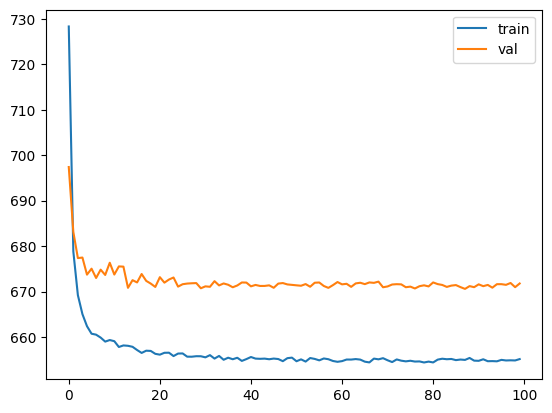

In [318]:
plt.plot(train_history, label="train")
plt.plot(val_history, label="val")
plt.legend()

### encoding decoding specific face 

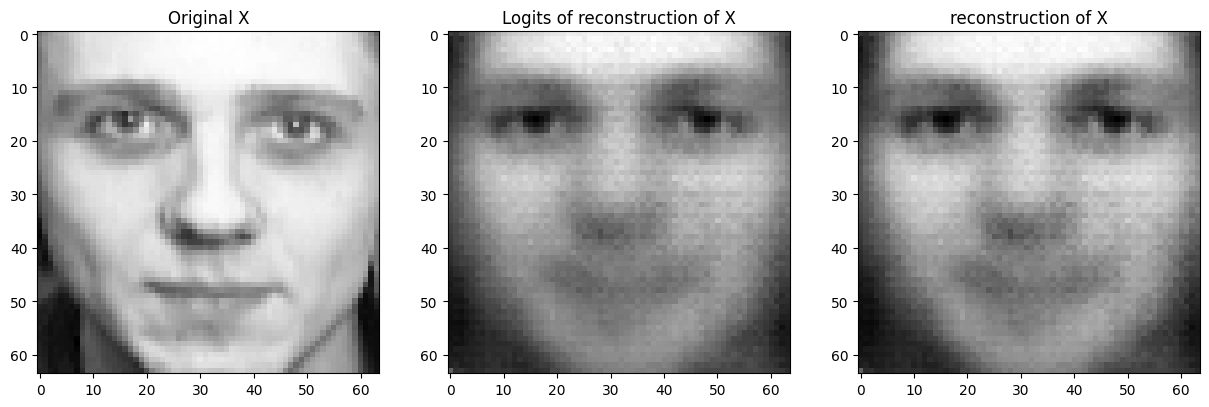

In [319]:
idx = 21
X_sample = X_test[idx].unsqueeze(1).to('cuda')

y_pred, _, _, _ = generator(X_sample)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(X_sample.cpu().squeeze(), cmap='gray')
ax1.set_title("Original X")

ax2.imshow(y_pred.cpu().squeeze().detach(), cmap='gray')
ax2.set_title("Logits of reconstruction of X")

ax3.imshow(F.sigmoid(y_pred).cpu().squeeze().detach(), cmap='gray')
ax3.set_title("reconstruction of X")

plt.show()

### sampling on the $z$-dimension manifold

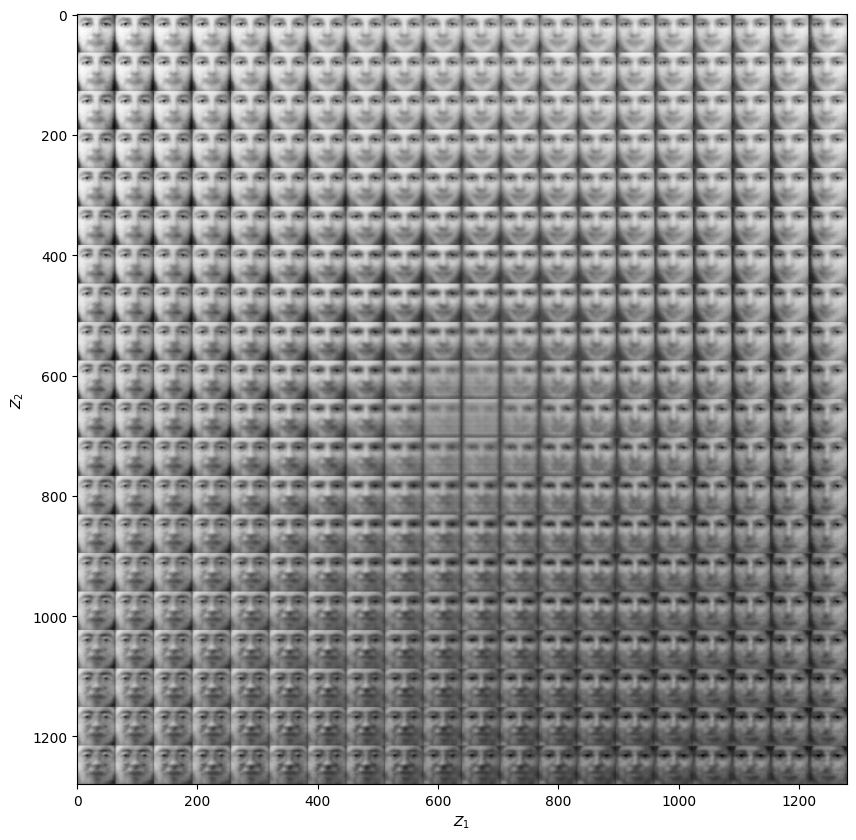

In [338]:
h, w = 20, 20
z1_range = torch.linspace(-1000, 1000, h)
z2_range = torch.linspace(-1000, 1000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')

# plt.savefig("../images/manifolds/faces.svg", dpi=300)

### random sampling if $z > 2$

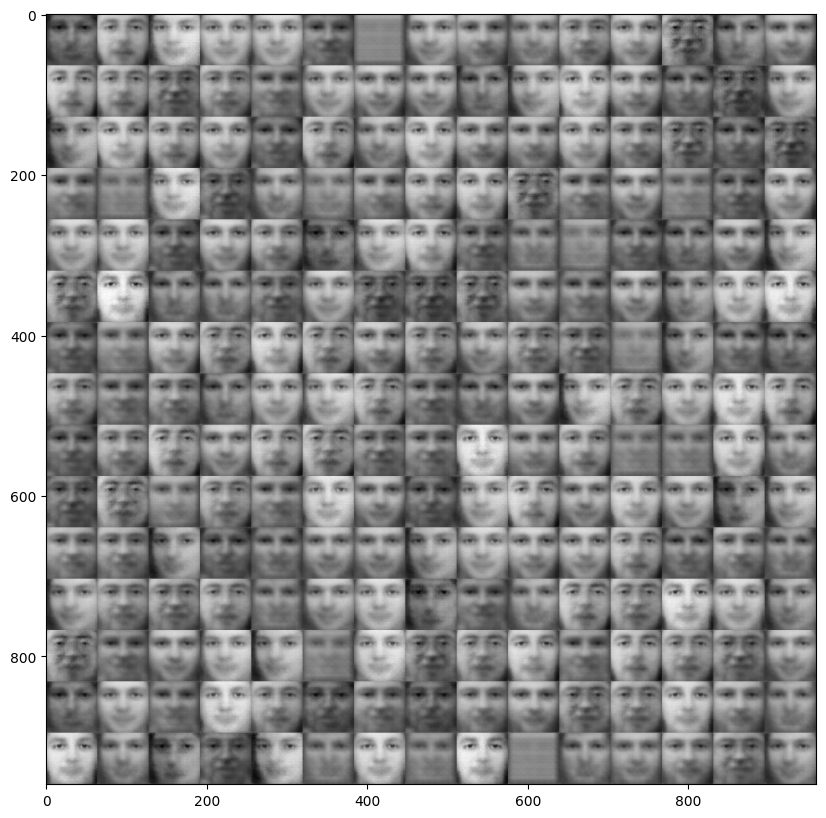

In [343]:
# h, w = 15, 15
# z_vecs = torch.randn(h*w, Z_SIZE, 1, 1).to('cuda')
# 
# y_preds = F.sigmoid(generator.dec(z_vecs)).squeeze().cpu().detach()
# y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)
# 
# plt.figure(figsize=(10, 10))
# plt.imshow(y_preds, cmap='gray')

## Generative Adverserial Networks


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

### Generator (decoder) and discriminator (encoder)

In [35]:
class Generator(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 32 -> 16
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(256, 1, kernel_size=3, stride=2, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)


gen = Generator(z_size=2).to(DEVICE)
dis = Discriminator().to(DEVICE)
z = torch.randn(32, 2, 1, 1).to(DEVICE)
gen(z).shape, dis(gen(z)).shape

(torch.Size([32, 1, 32, 32]), torch.Size([32, 1]))

### Prepate dataset

In [36]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]))

### Training loss and step function

In [40]:
def criterion(y_pred, y_true):
    loss_dis = F.binary_cross_entropy(y_true, torch.ones_like(y_true)) + F.binary_cross_entropy(y_pred, torch.zeros_like(y_pred))
    loss_gen = F.binary_cross_entropy(y_pred, torch.ones_like(y_pred))
    return loss_dis + loss_gen

def step(images, D, G, optimizer_dis, optimizer_gen, train=True):
    ones = torch.ones((images.shape[0], 1), device=DEVICE)
    zeros = torch.zeros((images.shape[0], 1), device=DEVICE)
    images = images.to(DEVICE)
    
    z = torch.randn(images.shape[0], Z_DIM, 1, 1, device=DEVICE)
    fake_images = G(z)
    y_pred = D(fake_images.detach())
    y_true = D(images)
        
    loss_dis = F.binary_cross_entropy(y_true, ones) + F.binary_cross_entropy(y_pred, zeros)
    if train:
        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()
    
    # recompute y_pred since discriminator is changed
    y_pred = D(fake_images)
    loss_gen = F.binary_cross_entropy(y_pred, ones)
    if train:
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
    
    return loss_dis.item(), loss_gen.item()


### Training procedure

In [48]:
EPOCHS = 40
BATCH_SIZE = 128
Z_DIM = 2

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

generator = Generator(z_size=Z_DIM).to(DEVICE)
discriminator = Discriminator().to(DEVICE)

optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.02)
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=0.001)

scheduler_gen = torch.optim.lr_scheduler.ExponentialLR(optimizer_gen, gamma=0.95)
scheduler_dis = torch.optim.lr_scheduler.ExponentialLR(optimizer_dis, gamma=0.95)

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        
        loss_dis, loss_gen = step(images, discriminator, generator, optimizer_dis, optimizer_gen)
        batch_history.append([loss_dis, loss_gen])
        
    # update learning rate
    scheduler_gen.step()
    scheduler_dis.step()
    
    mean_loss_dis, mean_loss_gen = np.mean(batch_history, axis=0)
    train_history.append([mean_loss_dis, mean_loss_gen])

    with torch.no_grad():
        loss_dis, loss_gen = step(X_val.to(DEVICE), discriminator, generator, optimizer_dis, optimizer_gen, train=False)
        val_history.append([loss_dis, loss_gen])
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    loss_dis, loss_gen = step(X_test.to(DEVICE), discriminator, generator, optimizer_dis, optimizer_gen, train=False)
    print(f"test_loss: {loss_dis}, {loss_gen}")

epoch 0, train_loss [0.07278226714478922, 7.650699485339589], val_loss [0.032305896282196045, 4.62384033203125]
epoch 1, train_loss [0.035323804153054, 6.148149594569257], val_loss [0.040854040533304214, 6.025323390960693]
epoch 2, train_loss [0.056005257429547116, 5.709547731449514], val_loss [0.02136959880590439, 4.777580261230469]
epoch 3, train_loss [0.06733693633211661, 6.044023929819115], val_loss [0.07168687880039215, 3.6000983715057373]
epoch 4, train_loss [0.021859666819114294, 5.5120203967795955], val_loss [0.0072461506351828575, 5.754764080047607]
epoch 5, train_loss [0.023356074062205835, 5.955346126546229], val_loss [0.011817816644906998, 5.273542881011963]
epoch 6, train_loss [0.019826633552375284, 6.089712076349808], val_loss [0.015198036096990108, 5.206912994384766]
epoch 7, train_loss [0.037828505694516686, 5.996935248120761], val_loss [0.01207755133509636, 4.801703929901123]
epoch 8, train_loss [0.00927004478037802, 6.492310813749269], val_loss [0.026799483224749565, 

### Visualize training progress 

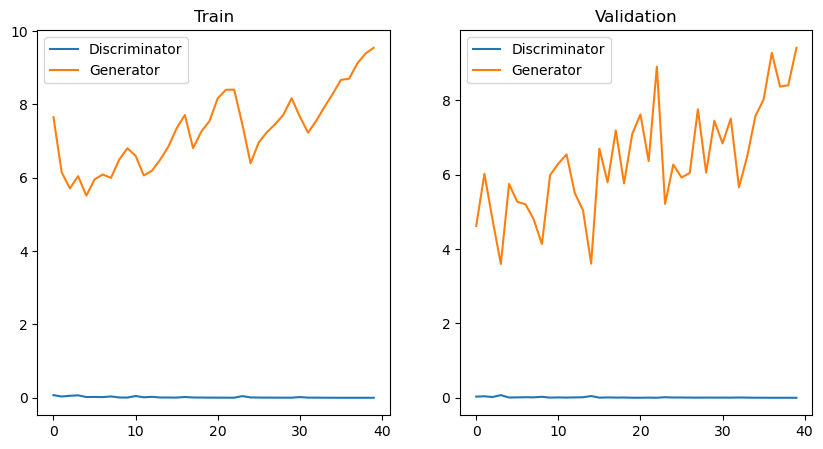

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

np_train_history = np.array(train_history)
np_val_history = np.array(val_history)

ax1.plot(np_train_history[:, 0], label="Discriminator")
ax1.plot(np_train_history[:, 1], label="Generator")
ax1.set_title("Train")
ax1.legend()

ax2.plot(np_val_history[:, 0], label="Discriminator")
ax2.plot(np_val_history[:, 1], label="Generator")
ax2.set_title("Validation")
ax2.legend()

### Sample from Z-space

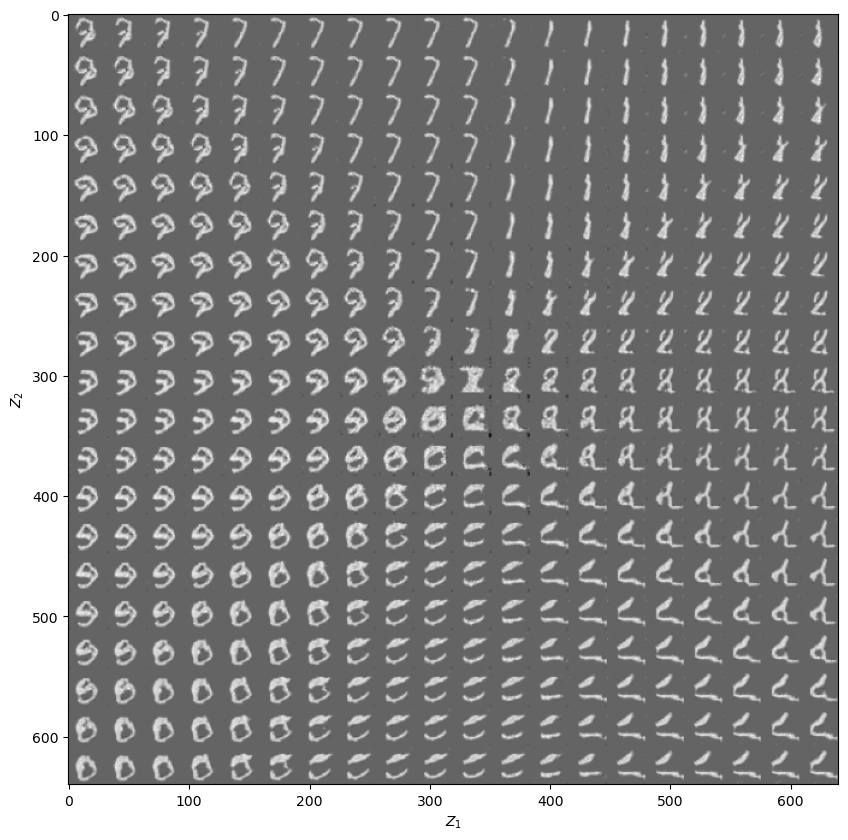

In [50]:
IMG_SIZE = 32

h, w = 20, 20
z1_range = torch.linspace(-1000, 1000, h)
z2_range = torch.linspace(-1000, 1000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = generator(zz).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, IMG_SIZE, IMG_SIZE).permute(1, 2, 0, 3).reshape(h*IMG_SIZE, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')

plt.show()
# plt.savefig("../images/manifolds/faces.svg", dpi=300)

## Another GAN example

In [112]:
import scipy.io
mat = scipy.io.loadmat('../datasets/olivettifaces.mat')

### train/test/val split

In [113]:
dataset = (mat['faces'].T.reshape(-1, 1, 64, 64))
dataset = np.transpose(dataset, axes=(0, 1, 3, 2)).astype('float32')

dataset = (dataset - np.min(dataset))/np.ptp(dataset)

dataset = torch.tensor(dataset)

mask = np.ones((dataset.shape[0]), bool)
idx = np.random.choice(dataset.shape[0], size=int(0.2 * dataset.shape[0]), replace=False)
mask[idx] = False

X_train = dataset[mask]
X_test = dataset[~mask][:idx.shape[0]//2]
X_val = dataset[~mask][idx.shape[0]//2:]

(X_train.shape, X_test.shape, X_val.shape)

(torch.Size([320, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]))

### 64x64 Generator and discriminator

In [114]:
class Generator64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 64
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

class Discriminator64x64(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 64 -> 32
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 16
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(512, 1, kernel_size=3, stride=2, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

gen = Generator64x64(z_size=2).to('cuda')
dis = Discriminator64x64().to('cuda')
z = torch.randn(32, 2, 1, 1).to('cuda')
gen(z).shape, dis(gen(z)).shape

(torch.Size([32, 1, 64, 64]), torch.Size([32, 1]))

### Training procedure

In [119]:
EPOCHS = 100
BATCH_SIZE = 16
Z_DIM = 100

train_loader = torch.utils.data.DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)

generator = Generator64x64(z_size=Z_DIM).to('cuda')
discriminator = Discriminator64x64().to('cuda')

optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

scheduler_gen = torch.optim.lr_scheduler.ExponentialLR(optimizer_gen, gamma=0.9)
scheduler_dis = torch.optim.lr_scheduler.ExponentialLR(optimizer_dis, gamma=0.9)

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, images in enumerate(train_loader):
        
        loss_dis, loss_gen = step(images, discriminator, generator)
        batch_history.append([loss_dis, loss_gen])
        
    # update learning rate
    scheduler_gen.step()
    scheduler_dis.step()
    
    mean_loss_dis, mean_loss_gen = np.mean(batch_history, axis=0)
    train_history.append([mean_loss_dis, mean_loss_gen])

    with torch.no_grad():
        loss_dis, loss_gen = step(X_val.to('cuda'), discriminator, generator, train=False)
        val_history.append([loss_dis, loss_gen])
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    loss_dis, loss_gen = step(X_test.to('cuda'), discriminator, generator, train=False)
    print(f"test_loss: {loss_dis}, {loss_gen}")

epoch 0, train_loss [1.5236458756029605, 5.6219712674617766], val_loss [0.28518617153167725, 2.256653308868408]
epoch 1, train_loss [0.3788230017235037, 5.9301252365112305], val_loss [0.009781758300960064, 4.7911882400512695]
epoch 2, train_loss [7.8574905149689585, 15.557798682153225], val_loss [0.18479759991168976, 2.194516897201538]
epoch 3, train_loss [0.2304693062324077, 5.309752511978149], val_loss [0.05630394443869591, 3.273711919784546]
epoch 4, train_loss [0.20584424077533187, 8.628778886795043], val_loss [22.278650283813477, 41.126609802246094]
epoch 5, train_loss [2.6510488599538804, 8.230315899848938], val_loss [1.1412285566329956, 1.2336405515670776]
epoch 6, train_loss [0.9715626046061516, 5.564654171466827], val_loss [3.070526123046875, 9.062799453735352]
epoch 7, train_loss [1.2367214381694793, 5.30018321275711], val_loss [4.466721057891846, 6.6153244972229]
epoch 8, train_loss [1.2645094886422157, 4.491126322746277], val_loss [0.6919172406196594, 3.3135273456573486]
ep

### Visualize training progress 

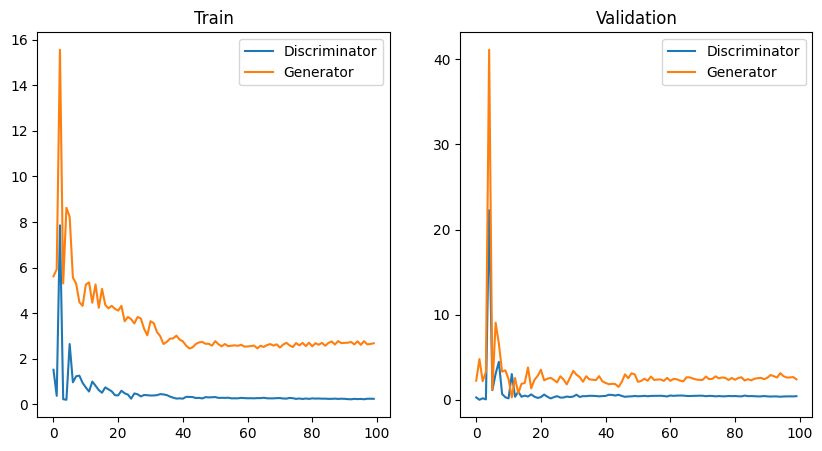

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

np_train_history = np.array(train_history)
np_val_history = np.array(val_history)

ax1.plot(np_train_history[:, 0], label="Discriminator")
ax1.plot(np_train_history[:, 1], label="Generator")
ax1.set_title("Train")
ax1.legend()

ax2.plot(np_val_history[:, 0], label="Discriminator")
ax2.plot(np_val_history[:, 1], label="Generator")
ax2.set_title("Validation")
ax2.legend()

### Sample from Z-space

In [117]:
IMG_SIZE = 64

h, w = 20, 20
z1_range = torch.linspace(-1000, 1000, h)
z2_range = torch.linspace(-1000, 1000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = generator(zz).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, IMG_SIZE, IMG_SIZE).permute(1, 2, 0, 3).reshape(h*IMG_SIZE, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')

plt.show()
# plt.savefig("../images/manifolds/faces.svg", dpi=300)

RuntimeError: Given transposed=1, weight of size [100, 512, 4, 4], expected input[400, 2, 1, 1] to have 100 channels, but got 2 channels instead

### Random sampling when $z > 2$

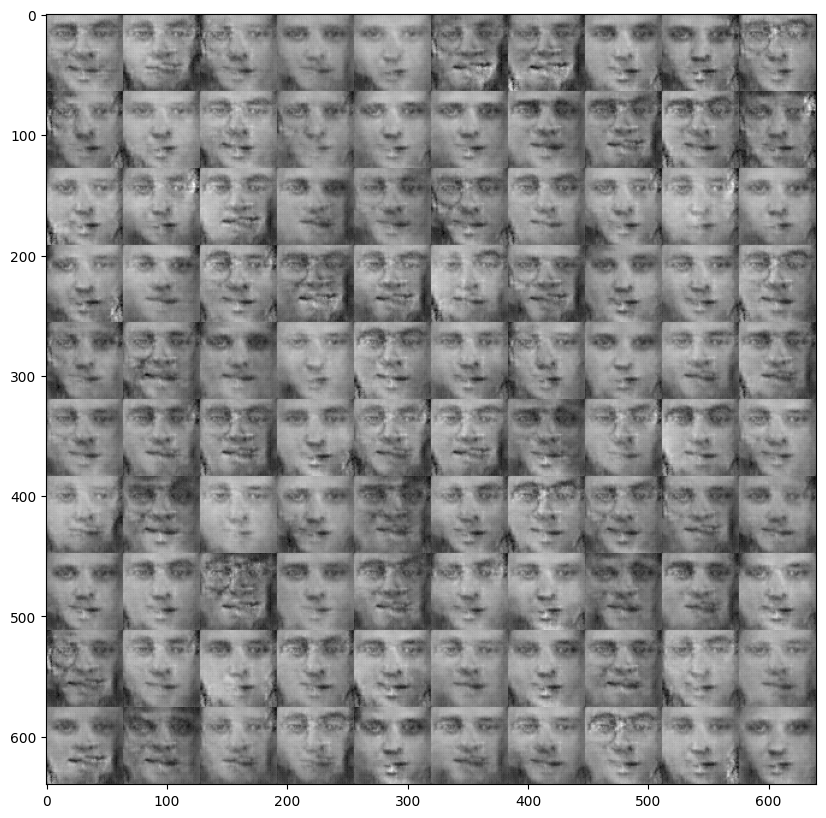

In [125]:
h, w = 10, 10
z_vecs = torch.randn(h*w, Z_DIM, 1, 1).to('cuda')

y_preds = generator(z_vecs).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')

## Diffusion models

- De-noising neural network $\epsilon(X_t, t)$ produces estimate of the amount of noise that was added to $X_{t-1}$
- Forward noise process: add Gaussian noise in $T$ time steps to $X_0$ until it is indistinguishable
- Backward noise process: learn the noise that was added in the forward process and reverse the process by $\hat{X}_{t-1} = X_t - \epsilon(X_t, t)$

In [25]:
class PixelDiffusionModel(nn.Module):
    def __init__(self, z_size=2):
        super(PixelDiffusionModel, self).__init__()
        self.enc = Encoder64x64(z_size=z_size)
        self.dec = Decoder64x64(z_size=z_size+1)
    
    def forward(self, x, t):
        # x shape: (batch_size, channels, W, H)
        # t shape: (batch_size, 1)
        z = self.enc(x)
        z = torch.hstack([z, t.reshape(-1, 1, 1, 1)])
        eps = self.dec(z)
        return eps

model = PixelDiffusionModel(z_size=2)
x = torch.randn(32, 1, 64, 64)
t = torch.randn(32, 1)
out = model(x, t)
out.shape

torch.Size([32, 1, 64, 64])

In [26]:
dataset = (mat['faces'].T.reshape(-1, 1, 64, 64))
dataset = np.transpose(dataset, axes=(0, 1, 3, 2)).astype('float32')

dataset = (dataset - np.min(dataset))/np.ptp(dataset)

dataset = torch.tensor(dataset)

mask = np.ones((dataset.shape[0]), bool)
idx = np.random.choice(dataset.shape[0], size=int(0.2 * dataset.shape[0]), replace=False)
mask[idx] = False

X_train = dataset[mask]
X_test = dataset[~mask][:idx.shape[0]//2]
X_val = dataset[~mask][idx.shape[0]//2:]

(X_train.shape, X_test.shape, X_val.shape)

(torch.Size([320, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]))

In [33]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

for batch in train_loader:
    print(batch.shape)

torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
t

In [37]:
EPOCHS = 100
Z_SIZE = 2
batch_size = 8

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

generator = PixelDiffusionModel(z_size=Z_SIZE).to('cuda')

optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.MSELoss()

train_history = []
val_history = []

T = 30
beta = 1.5

for epoch in range(EPOCHS):
    batch_history = []
    for i, images in enumerate(train_loader):
        images = images.to('cuda')
        
        # (T, batch_size, channels, W, H)
        eps = beta*torch.randn((T, *images.shape)).to('cuda')
        
        total_loss = torch.zeros(1).to('cuda')
        
        for j, eps_j in enumerate(eps):
        
            noisy_images = images + eps_j
            t = torch.broadcast_to(torch.tensor([[j]]), (batch_size, 1)).to('cuda')
            eps_prev = generator(noisy_images, t)
            
            total_loss += criterion(eps_prev, eps_j)
            
        batch_history.append(total_loss.item())
        # optimization step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        eps = beta * torch.randn((T, *X_val.shape)).to('cuda')
        total_loss = torch.zeros(1).to('cuda')
        for j, eps_j in enumerate(eps):
        
            noisy_images = X_val.to('cuda') + eps_j
            t = torch.broadcast_to(torch.tensor([[j]]), (X_val.shape[0], 1)).to('cuda')
            eps_prev = generator(noisy_images, t)
            
            total_loss += criterion(eps_prev, eps_j)
            
        val_history.append(total_loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

# with torch.no_grad():
#     preds, z, mu, sigma = generator(X_test.to('cuda'))
#     kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
#     rec_error = lambda_rec_error * criterion(preds, X_test.to('cuda'))
#     loss = rec_error + kl_reg
#     print(f"test_loss {loss.item()}")

epoch 0, train_loss 78.0226058959961, val_loss 67.76443481445312
epoch 1, train_loss 67.61810302734375, val_loss 67.54793548583984
epoch 2, train_loss 67.54386901855469, val_loss 67.5054931640625
epoch 3, train_loss 67.51223754882812, val_loss 67.55072021484375
epoch 4, train_loss 67.53981018066406, val_loss 67.44760131835938
epoch 5, train_loss 67.51161193847656, val_loss 67.47394561767578
epoch 6, train_loss 67.48857116699219, val_loss 67.53124237060547
epoch 7, train_loss 67.51541137695312, val_loss 67.54813385009766
epoch 8, train_loss 67.49281311035156, val_loss 67.47198486328125
epoch 9, train_loss 67.48748779296875, val_loss 67.49430847167969
epoch 10, train_loss 67.4937744140625, val_loss 67.47531127929688
epoch 11, train_loss 67.5085220336914, val_loss 67.5287857055664
epoch 12, train_loss 67.51374053955078, val_loss 67.54545593261719
epoch 13, train_loss 67.52588653564453, val_loss 67.47704315185547
epoch 14, train_loss 67.48443603515625, val_loss 67.50444030761719
epoch 15, 

KeyboardInterrupt: 